In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [3]:
#hyperparamters for first plot
N = int(1e3)

#hyper for oscillator
m = 1.0
k = 1.0
X_max = 1
delta = 0.5

#tłumione będą gdy sqrt(k/m) > delta/m
omega = np.sqrt(k/m) #8 sekund okres

T = 2 * np.pi / omega
t_end = T * 4
t_start = 0
n_internal = 103
dt = (T*4) / (n_internal + 1) # dt musi być takie samo dla Linear i RNN!
print(omega > delta/m)

def oscillator(t,y):
  x, v = y
  dxdt = v
  dvdt = (-k/m)*x - delta*v

  return [dxdt,dvdt]

True


In [4]:
def data_linear(t_start, t_end, N, x0, v0):
  t_eval = np.linspace(t_start, t_end, N)
  sol = solve_ivp(oscillator, [t_start, t_end], [x0, v0], t_eval= t_eval)
  x = sol.y[0]
  v = sol.y[1]

  return x[1:],v[1:]


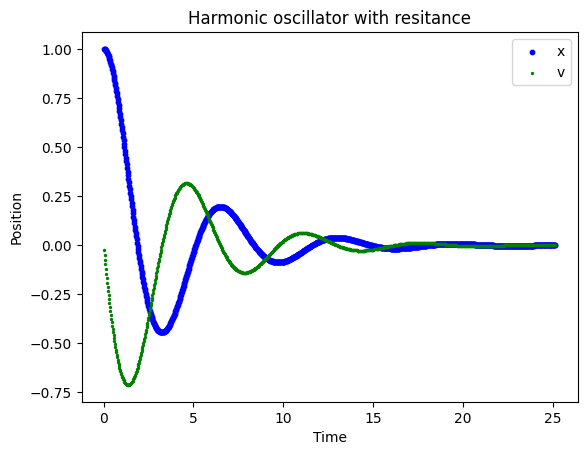

In [5]:
t = torch.linspace(t_start, t_end, N)[1:]
x, v= data_linear(t_start, t_end, N, X_max, 0.0)
plt.scatter(t,x, s = 10, color = 'blue', label = 'x')
plt.scatter(t,v, s = 2, color = 'green', label = 'v')
plt.legend()
plt.title("Harmonic oscillator with resitance")
plt.xlabel("Time")
plt.ylabel("Position")
plt.show()

In [6]:
dt = (T/4) / (n_internal + 1)
print(dt)

0.015103810834566312


In [7]:
#tutaj dane będa uporzadkowane
#celem jest dostarczenie modelowi warunkow poczatkowych tj [x0, v0]
#ma przewidziec 'window' kolejnych kroków w przód odległych o delta t
#stałe bedzie t_start, t_end, N. Zmienne bedzie x,v
#format danych bedzie (batch_size, 2)
def loader_linear_harmonic():
  data = [] #(batch_size, 2) bo [x0,v0]
  y_true = [] #(batch_size, 2)

  #E = 0.5*mv^2 + 0.5*kx^2 = const = 0.5*k*X_max^2
  n_data = 30000 # de facto razy dwa to bedzie, bo +-v
  N = 3 #ile w przod przewiduje

  T = 2 * np.pi / omega
  t_end = T * 4
  t_start = 0
  n_internal = 103
  dt = t_end / (n_internal + 1)
  N = 3

  x_random = np.random.uniform(-1,1, n_data)
  x0 = x_random*X_max
  v0_plus = [np.sqrt(k*(X_max**2 - x**2)/m)  for x in x0]
  v0_minus = [-np.sqrt(k*(X_max**2 - x**2)/m)  for x in x0]

  i = 0
  for x_initial, v_plus, v_minus in zip(x0, v0_plus, v0_minus):

    x_plus, v_1 = data_linear(t_start, dt*3, N+1, x_initial, v_plus) #N+1 bo nie zawiera juz w. pocz.
    x_minus, v_2 = data_linear(t_start, dt*3, N+1, x_initial, v_minus)

    data.append([x_initial, v_plus])
    data.append([x_initial, v_minus])
    y_true.append([x_plus, v_1])
    y_true.append([x_minus, v_2])

  data = np.array(data)
  y_true = np.transpose(np.array(y_true), (0,2,1))
  data = torch.tensor(data, dtype = torch.float32)
  y_true = torch.tensor(y_true, dtype = torch.float32)

  dataset = TensorDataset(data, y_true)
  loader = DataLoader(dataset, batch_size=64, shuffle=True)

  print(f"Shape of data: {data.shape}")
  print(f"Shape of targets: {y_true.shape}")

  return dataset, loader

In [ ]:
def val_loader_linear_harmonic():
  data_val = [] #(batch_size, 2) bo [x0,v0]
  y_true_val = [] #(batch_size, 2)

  T = 2 * np.pi / omega
  t_end = T * 4
  t_start = 0
  n_internal = 103
  dt = t_end / (n_internal + 1)
  n_data = 1000
  N = 3

  x_random = np.random.uniform(-1,1, n_data)
  x0 = x_random*X_max
  v0_plus = [np.sqrt(k*(X_max**2 - x**2)/m)  for x in x0]
  v0_minus = [-np.sqrt(k*(X_max**2 - x**2)/m)  for x in x0]

  i = 0
  for x_initial, v_plus, v_minus in zip(x0, v0_plus, v0_minus):

    x_plus, v_1 = data_linear(t_start, dt*3, N+1, x_initial, v_plus) #N+1 bo nie zawiera juz w. pocz.
    x_minus, v_2 = data_linear(t_start, dt*3, N+1, x_initial, v_minus)

    data_val.append([x_initial, v_plus])
    data_val.append([x_initial, v_minus])
    y_true_val.append([x_plus, v_1])
    y_true_val.append([x_minus, v_2])

  data_val = np.array(data_val)
  y_true_val = np.transpose(np.array(y_true_val), (0,2,1))
  data_val = torch.tensor(data_val,dtype = torch.float32)
  y_true_val = torch.tensor(y_true_val,dtype = torch.float32)

  dataset_val = TensorDataset(data_val, y_true_val)
  loader_val = DataLoader(dataset_val, batch_size = 64, shuffle = False)

  print(f"Shape of validation data: {data_val.shape}")
  print(f"Shape of validation targets: {y_true_val.shape}")
  return dataset_val, loader_val

In [9]:
class Linear(nn.Module):
  def __init__(self, input_size = 2, output_size = (3,2), num_neurons = 40):
    super().__init__()

    self.input_size = 2
    self.output_size = output_size
    self.num_neurons = num_neurons
    self.l1 = nn.Linear(self.input_size, self.num_neurons)
    self.l2 = nn.Linear(self.num_neurons, self.num_neurons)
    self.l3 = nn.Linear(self.num_neurons, self.num_neurons//2)
    self.l4 = nn.Linear(self.num_neurons//2, output_size[0]*2)

  def forward(self, sample):
    x = F.tanh(self.l1(sample))

    x = F.tanh(self.l2(x))

    x = F.tanh(self.l3(x))
    x = self.l4(x)
    x = x.view(-1, self.output_size[0], 2) #bedzie (batch, ktore delta t, [x,v])

    return x

  def param(self):
    total_param = sum(p.numel() for p in self.parameters())
    print("Total parameters:", total_param)


In [10]:
def loss_physics(pred, target, dt):
  #Loss = mean suma Res^2, gdzie Res = d2xdt2*m + kx
  #pred to bedzie (batch_size, timestep=3, [x,v]
  #nie uda sie przez autograd
  x = pred[:,:,0] #(batch, 3) ->2 predkosci
  v = pred[:,:,1] #(batch, 3)

  dx = x[:, 1:] - x[:, :-1]
  v_pred = dx/dt

  loss_1 = torch.mean((v_pred - v[:, 1:])**2) # z tego że dx/dt = v


  dv = v[:, 1:] - v[:, :-1]
  a_pred = dv/dt
  Res = m*a_pred + k*x[:,1:] + delta*v[:,1:]

  loss_2 = torch.mean(Res**2)
  w_kinematic = 1.0
  w_dynamic = 1.0
  loss = loss_1*w_kinematic + loss_2*w_dynamic
  return loss*dt**2


In [ ]:
def training(linear, loader, loader_val):

  epochs = 50
  eta = 0.001
  T = 2 * np.pi / omega
  t_end = T * 4
  t_start = 0
  n_internal = 103
  dt = t_end / (n_internal + 1)

  loss = nn.MSELoss()
  optimizer = torch.optim.Adam(linear.parameters(), lr = eta)
  plateu = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor=0.2, patience = 3, threshold=0.001,threshold_mode = 'rel', cooldown=3)


  #phys_weight zaczyna od małej wartosci rzędu 1 aż do około 1500 przy epoce 10
  phys_weight = np.concatenate((np.linspace(1, 1000, 20), [1000]*30))
  previous_eta = eta
  loss_history = []


  for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs+1}")
    current_lr = optimizer.param_groups[0]['lr']

    if current_lr < previous_eta:
      previous_eta = current_lr
      print("Plateu!")
    print(f"Eta: {current_lr}")

    epoch_loss = 0.0
    val_loss = 0.0

    linear.train()
    for batch in loader:
      sample, target = batch
      pred = linear(sample)

      l1 = loss(pred, target)
      l2 = loss_physics(pred, target, dt)
      l = (l1 + l2)

      l.backward()
      epoch_loss += l.detach()
      optimizer.step()
      optimizer.zero_grad()

    linear.eval()
    for batch_val in loader_val:
      sample, target = batch_val
      pred = linear(sample)

      l1 = loss(pred, target)
      l2 = loss_physics(pred, target, dt)
      val_loss += (l1+l2).item()

    val_loss = val_loss/len(loader_val)
    epoch_loss = epoch_loss/len(loader)
    plateu.step(val_loss)

    print(f"Total loss: {epoch_loss}\nValidation loss: {val_loss}\n")
    loss_history.append(val_loss)

  return linear, loss_history

In [12]:
dataset, loader = loader_linear_harmonic()
dataset_val, val_loader = val_loader_linear_harmonic()

Shape of data: torch.Size([60000, 2])
Shape of targets: torch.Size([60000, 3, 2])
Shape of validation data: torch.Size([2000, 2])
Shape of validation targets: torch.Size([2000, 3, 2])


In [13]:
linear = Linear()
linear.param()
linear, loss_history = training(linear, loader, val_loader)

Total parameters: 2706


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
Eta: 0.001
Total loss: 0.013477650471031666
Validation loss: 0.0001710431770334253

Epoch 2
Eta: 0.001
Total loss: 0.0001670554920565337
Validation loss: 0.0001643961745685374

Epoch 3
Eta: 0.001
Total loss: 0.0001624987053219229
Validation loss: 0.00016214819652304868

Epoch 4
Eta: 0.001
Total loss: 0.0001604503340786323
Validation loss: 0.0001596466559021792

Epoch 5
Eta: 0.001
Total loss: 0.00016090775898192078
Validation loss: 0.00015923528189887293

Epoch 6
Eta: 0.001
Total loss: 0.00016351461817976087
Validation loss: 0.00016031045743147843

Epoch 7
Eta: 0.001
Total loss: 0.00016327647608704865
Validation loss: 0.0001582880267960718

Epoch 8
Eta: 0.001
Total loss: 0.0001616193912923336
Validation loss: 0.00016001345602489891

Epoch 9
Eta: 0.001
Total loss: 0.0001622830459382385
Validation loss: 0.0001595177404851711

Epoch 10
Eta: 0.001
Total loss: 0.00016300813877023757
Validation loss: 0.00016756642162363278

Epoch 11
Eta: 0.001
Total loss: 0.00016151387535501271
Valida

RNN

In [14]:
#tutaj nie chcemy 3
T = 2*np.pi/omega
n = 103
dt = T*4/(n+1)

def data_rnn(x0, v0, n, t_start=0, t_end=T*4):
  t_eval = np.linspace(t_start, t_end, n)
  sol = solve_ivp(oscillator, [t_start, t_end], [x0, v0], t_eval= t_eval)
  x = sol.y[0]
  v = sol.y[1]
  x_rnn =[]
  v_rnn =[]

  for idx in range(n-3):
    x_rnn.append([x[idx:idx+4]])
    v_rnn.append([v[idx:idx+4]])

  x_rnn = np.array(x_rnn)
  v_rnn = np.array(v_rnn)
  x_rnn = x_rnn.transpose((0,2,1))
  v_rnn = v_rnn.transpose((0,2,1))


  return x_rnn,v_rnn

x,v = data_rnn(0,1, n)
print(f"dt to procent okresu {dt/T*100}")
print(np.shape(x), np.shape(v))

dt to procent okresu 3.846153846153846
(100, 4, 1) (100, 4, 1)


In [22]:
batch_size = 64
def loader_rnn_harmonic():
  data = [] #(batch_size, 2) bo [x0,v0]
  y_true = [] #(batch_size, 2)

  #E = 0.5*mv^2 + 0.5*kx^2 = const = 0.5*k*X_max^2
  t_start = 0
  t_end = T*4 #okres jest 6.5s -> 1/60 okresu
  n_data = 300 #danych bedzie 100 * 2 razy wiecej
  n = 104

  x_random = np.random.uniform(-1,1, n_data)
  x0 = x_random*X_max
  v0_plus = [np.sqrt(k*(X_max**2 - x**2)/m)  for x in x0]
  v0_minus = [-np.sqrt(k*(X_max**2 - x**2)/m)  for x in x0]

  for x_initial, v_plus, v_minus in zip(x0, v0_plus, v0_minus):

    x_plus, v_1 = data_rnn(x_initial, v_plus, n) # x_plus bedzie (100,4,1), v_plus (100,4,1)
    x_minus, v_2 = data_rnn(x_initial, v_minus, n)

    data.append(np.concatenate ((x_plus[:-1], v_1[:-1]), axis = 2))
    data.append(np.concatenate((x_minus[:-1], v_2[:-1]), axis = 2))

    y_true.append(np.concatenate ((x_plus[1:, -1, :], v_1[1:, -1, :]), axis = 1))
    y_true.append(np.concatenate ((x_minus[1:, -1, :], v_2[1:, -1, :]), axis = 1))

  data = np.concatenate(data, axis=0)
  y_true = np.concatenate(y_true, axis=0)

  data = torch.tensor(data, dtype = torch.float32)
  y_true = torch.tensor(y_true, dtype = torch.float32)

  dataset = TensorDataset(data, y_true)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  print(f"Shape of data: {data.shape}")
  print(f"Shape of targets: {y_true.shape}")
  return dataset, loader

In [23]:

def val_loader_rnn_harmonic():
  data_val = [] #(batch_size, 2) bo [x0,v0]
  y_true_val = [] #(batch_size, 2)

  #E = 0.5*mv^2 + 0.5*kx^2 = const = 0.5*k*X_max^2
  t_start = 0
  t_end = T*4 #okres jest 6.5s -> 1/60 okresu
  n_data = 10 #danych bedzie 100 * 2 razy wiecej
  n = 104

  x_random = np.random.uniform(-1,1, n_data)
  x0 = x_random*X_max
  v0_plus = [np.sqrt(k*(X_max**2 - x**2)/m)  for x in x0]
  v0_minus = [-np.sqrt(k*(X_max**2 - x**2)/m)  for x in x0]

  for x_initial, v_plus, v_minus in zip(x0, v0_plus, v0_minus):

    x_plus, v_1 = data_rnn(x_initial, v_plus, n) # x_plus bedzie (100,4,1), v_plus (100,4,1)
    x_minus, v_2 = data_rnn(x_initial, v_minus, n)

    data_val.append(np.concatenate ((x_plus[:-1], v_1[:-1]), axis = 2))
    data_val.append(np.concatenate((x_minus[:-1], v_2[:-1]), axis = 2))

    y_true_val.append(np.concatenate ((x_plus[1:, -1, :], v_1[1:, -1, :]), axis = 1))
    y_true_val.append(np.concatenate ((x_minus[1:, -1, :], v_2[1:, -1, :]), axis = 1))

  data_val = np.concatenate(data_val, axis=0)
  y_true_val = np.concatenate(y_true_val, axis=0)

  data_val = torch.tensor(data_val, dtype = torch.float32)
  y_true_val = torch.tensor(y_true_val, dtype = torch.float32)

  dataset = TensorDataset(data_val, y_true_val)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  print(f"Shape of data: {data_val.shape}")
  print(f"Shape of targets: {y_true_val.shape}")
  return dataset, loader

In [24]:
class RNN(nn.Module):
  def __init__(self, input_size = 2,  hidden_size = 32, num_layers_lstm = 2, output_size =2):
    super().__init__()
    self.input_size = input_size #bo 2 od sample 4 od h i 4 od c
    self.hidden_size = hidden_size
    self.num_layers_lstm = num_layers_lstm
    self.output_size = output_size

    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers_lstm, batch_first=True) #zwraca (batch, 4, 2)
    self.l1 = nn.Linear(self.hidden_size, 60)
    self.l2 = nn.Linear(60, 80)
    self.l3 = nn.Linear(80, 40)
    self.l4 = nn.Linear(40, 20)
    self.l5 = nn.Linear(20, self.output_size)

  def forward(self, sample): #sample (batch, seq=4, feat =2)

    x, (h, c) = self.lstm(sample) #nie chce zapisaywac poprzednich batchy bo bede robil shuffle, (num_leyers, bacth, hiddenisze)
    # x = x.reshape(x.size(0), -1)
    x = x[:, -1, :] # x jest (batch, seq, hidden_size)
    x = F.tanh(self.l1(x))
    x = F.tanh(self.l2(x))
    x = F.tanh(self.l3(x))
    x = F.tanh(self.l4(x))
    x = self.l5(x)
    return x

  def param(self):
    total_param = sum(p.numel() for p in self.parameters())
    print("Total parameters:", total_param)



In [25]:
def loss_physics_rnn(pred, target, dt, sample):
  x = pred[:,0] #(batch,) ->2 predkosci
  v = pred[:,1] #(batch,)
  #sample to (batch, seq, 1)
  dx = x - sample[:, -1, 0]
  v_pred = dx/dt

  loss_1 = torch.mean((v_pred - v)**2) # z tego że dx/dt = v


  dv = v - sample[:, -1, 1]
  a_pred = dv/dt

  Res = m*a_pred + k*x + delta*v

  loss_2 = torch.mean(Res**2)
  w_kinematic = 1.0
  w_dynamic = 1.0
  loss = loss_1*w_kinematic + loss_2*w_dynamic
  return loss*dt**2


In [19]:
def training_rnn(rnn, loader, loader_val):

  epochs = 20
  eta = 0.001
  t_end = T*4
  t_start = 0
  n = 103
  dt = (t_end-t_start)/(n+1)

  loss = nn.MSELoss()
  optimizer = torch.optim.Adam(rnn.parameters(), lr = eta)
  plateu = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor=0.2, patience = 3, threshold=0.001,threshold_mode = 'rel', cooldown=3)


  #phys_weight zaczyna od małej wartosci rzędu 1 aż do około 1500 przy epoce 10
  phys_weight = np.concatenate((np.linspace(1, 1000, 20), [1000]*30))
  previous_eta = eta
  loss_history = []


  for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")
    current_lr = optimizer.param_groups[0]['lr']

    if current_lr < previous_eta:
      previous_eta = current_lr
      print("Plateu!")
    print(f"Eta: {current_lr}")

    epoch_loss = 0.0
    val_loss = 0.0


    rnn.train()
    for idx,batch in enumerate(loader):
      sample, target = batch
      pred = rnn(sample)

      l1 = loss(pred, target)
      l2 = loss_physics_rnn(pred, target, dt, sample)
      l = l1+l2

      l.backward()
      epoch_loss += l.item()
      optimizer.step()
      optimizer.zero_grad()

    rnn.eval()
    with torch.no_grad():
      for idx,batch_val in enumerate(loader_val):
        sample, target = batch_val
        pred= rnn(sample)

        l1 = loss(pred, target)
        l2 = loss_physics_rnn(pred, target, dt, sample)
        l = l1+l2
        val_loss += l.item()
        print(l.item())

    val_loss /= len(loader_val)
    epoch_loss /= len(loader)
    plateu.step(val_loss)

    print(f"Total loss: {epoch_loss}\nValidation loss: {val_loss}\n")
    loss_history.append(val_loss)

  return rnn, loss_history

In [20]:
dataset, loader = loader_rnn_harmonic()
val_dataset, val_loader = val_loader_rnn_harmonic()
rnn = RNN()
rnn.train()
rnn.param()

Shape of data: torch.Size([60000, 4, 2])
Shape of targets: torch.Size([60000, 2])
Shape of data: torch.Size([2000, 4, 2])
Shape of targets: torch.Size([2000, 2])
Total parameters: 24018


In [26]:
def training_rnn(rnn, loader, loader_val):
    epochs = 20
    eta = 0.001

    # Parametry czasu
    t_end = T*4
    t_start = 0
    n = 103
    dt = (t_end - t_start) / (n + 1)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=eta)
    plateu = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, threshold=0.001, threshold_mode='rel', cooldown=3)

    # Wagi fizyki
    phys_weight = np.concatenate((np.linspace(1, 1000, 10), [1000]*10)) # Dopasowane do 20 epok

    previous_eta = eta
    loss_history = []

    for epoch in tqdm(range(epochs)):
        current_lr = optimizer.param_groups[0]['lr']

        # Pobranie wagi dla danej epoki
        w_phys = phys_weight[epoch] if epoch < len(phys_weight) else phys_weight[-1]

        if current_lr < previous_eta:
            previous_eta = current_lr
            print("Plateu!")
            print(f"Eta: {current_lr}")

        epoch_loss = 0.0
        val_loss = 0.0

        # --- TRENING ---
        rnn.train()
        for batch in loader:
            sample, target = batch
            optimizer.zero_grad() # Zerowanie na początku

            pred = rnn(sample)

            l1 = loss_fn(pred, target)
            l2 = loss_physics_rnn(pred, target, dt, sample)

            # Użycie wagi!
            l = l1 + (w_phys * l2)

            l.backward()
            epoch_loss += l.item() # Zbieramy .item()
            optimizer.step()

        # --- WALIDACJA ---
        rnn.eval()
        with torch.no_grad():
            for batch_val in loader_val:
                sample, target = batch_val
                pred = rnn(sample)

                l1 = loss_fn(pred, target)
                l2 = loss_physics_rnn(pred, target, dt, sample)

                # Sumujemy tak samo jak w treningu
                l = l1 + (w_phys * l2)
                val_loss += l.item()

        # --- POZA PĘTLAMI BATCHY (Tu był błąd wcięć) ---
        epoch_loss /= len(loader)
        val_loss /= len(loader_val)

        plateu.step(val_loss)

        print(f"Epoch {epoch+1} | Phys Weight: {w_phys:.1f}")
        print(f"Total loss: {epoch_loss:.6f} | Validation loss: {val_loss:.6f}\n")
        loss_history.append(val_loss)

    return rnn, loss_history

In [27]:
training_rnn(rnn, loader, val_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Phys Weight: 1.0
Total loss: 0.007973 | Validation loss: 0.000103

Epoch 2 | Phys Weight: 112.0
Total loss: 0.064252 | Validation loss: 0.000513

Epoch 3 | Phys Weight: 223.0
Total loss: 0.009487 | Validation loss: 0.001229

Epoch 4 | Phys Weight: 334.0
Total loss: 0.006597 | Validation loss: 0.001411

Epoch 5 | Phys Weight: 445.0
Total loss: 0.014627 | Validation loss: 0.010996

Plateu!
Eta: 0.0002
Epoch 6 | Phys Weight: 556.0
Total loss: 0.001316 | Validation loss: 0.001040

Epoch 7 | Phys Weight: 667.0
Total loss: 0.001541 | Validation loss: 0.001424

Epoch 8 | Phys Weight: 778.0
Total loss: 0.001935 | Validation loss: 0.001681

Epoch 9 | Phys Weight: 889.0
Total loss: 0.002499 | Validation loss: 0.004289

Epoch 10 | Phys Weight: 1000.0
Total loss: 0.002448 | Validation loss: 0.003176

Epoch 11 | Phys Weight: 1000.0
Total loss: 0.002022 | Validation loss: 0.002940

Epoch 12 | Phys Weight: 1000.0
Total loss: 0.001802 | Validation loss: 0.000754

Plateu!
Eta: 4e-05
Epoch 13 

(RNN(
   (lstm): LSTM(2, 32, num_layers=2, batch_first=True)
   (l1): Linear(in_features=32, out_features=60, bias=True)
   (l2): Linear(in_features=60, out_features=80, bias=True)
   (l3): Linear(in_features=80, out_features=40, bias=True)
   (l4): Linear(in_features=40, out_features=20, bias=True)
   (l5): Linear(in_features=20, out_features=2, bias=True)
 ),
 [0.00010349503349971201,
  0.0005131169431251692,
  0.0012292945135357058,
  0.001411467789694143,
  0.010995734020980308,
  0.0010399040997981501,
  0.0014244571484596236,
  0.0016806736439320957,
  0.004288504049327457,
  0.00317636055751791,
  0.002940394233519328,
  0.0007543589530882855,
  0.0007117036579984415,
  0.0010591759353246744,
  0.0006350248295348138,
  0.0007976234661555281,
  0.0007093720091688738,
  0.000573486446910465,
  0.0005094732297266091,
  0.00045569760982289154])

In [33]:
torch.save(linear.state_dict(), "harmonic_models/linear")
torch.save(rnn.state_dict(), "harmonic_models/rnn")

def load_models():
    linear = Linear()
    rnn = RNN()
    linear.load_state_dict(torch.load("harmonic_models/linear", weights_only=True))
    rnn.load_state_dict(torch.load("harmonic_models/rnn", weights_only=True))
    rnn.eval()
    linear.eval()
    
    return linear, rnn

l,r = load_models()

Start symulacji hybrydowej...
1. Linear Model: Generuje pierwsze 3 kroki z [x0, v0]
2. RNN Model:    Symuluje pozostałe 101 kroków


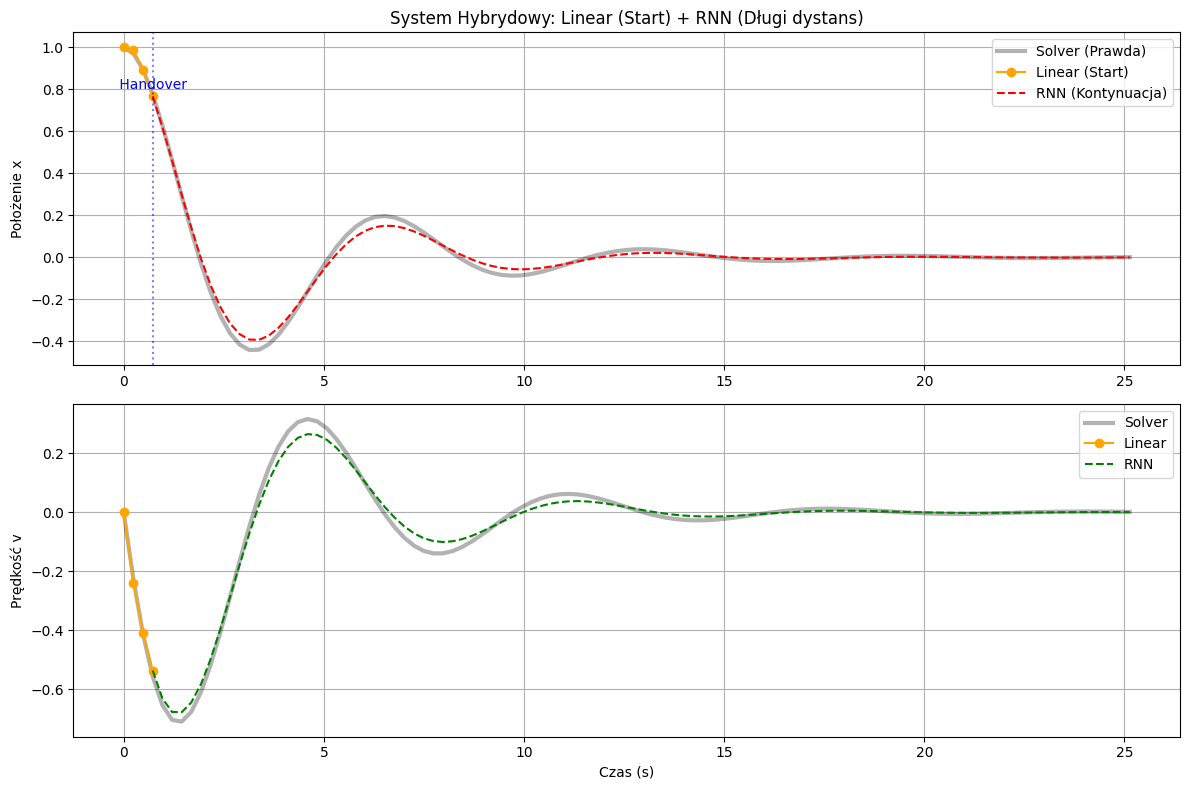

Całkowity błąd MSE układu hybrydowego: 0.000418


In [29]:
def evaluate_hybrid_system(linear_model, rnn_model, x0=1, v0=1):
    """
    1. Linear generuje 'rozbieg' (startując z jednego punktu).
    2. RNN przejmuje pałeczkę i symuluje resztę.
    """
    linear_model.eval()
    rnn_model.eval()
    linear.to(DEVICE)
    rnn.to(DEVICE)
    # --- USTAWIENIA CZASU (Zgodne z treningiem) ---
    # Parametry muszą być identyczne jak w treningu obu modeli
    T = 2 * np.pi / omega
    t_end = T * 4
    n_internal = 103
    dt = (T*4) / (n_internal + 1) # dt musi być takie samo dla Linear i RNN!

    # Oś czasu do solvera i wykresów
    num_steps = int(t_end / dt) + 1
    t_eval = np.linspace(0, t_end, num_steps)

    print(f"Start symulacji hybrydowej...")
    print(f"1. Linear Model: Generuje pierwsze 3 kroki z [x0, v0]")
    print(f"2. RNN Model:    Symuluje pozostałe {len(t_eval)-4} kroków")

    # --- ETAP 0: GROUND TRUTH (SOLVER) ---
    # Żebyśmy mieli z czym porównać
    k=1.0; m=1.0; delta=0.5
    def oscillator_func(t, y):
        x, v = y
        return [v, (-k/m)*x - delta*v]

    sol = solve_ivp(oscillator_func, [0, t_end], [x0, v0], t_eval=t_eval)
    true_x = sol.y[0]
    true_v = sol.y[1]

    with torch.no_grad():
        # ====================================================
        # ETAP 1: LINEAR MODEL (BOOTSTRAP)
        # ====================================================
        # Wejście: (1, 2) -> tylko [x0, v0]
        init_tensor = torch.tensor([[x0, v0]], dtype=torch.float32).to(DEVICE)

        # Linear przewiduje 3 kolejne kroki: (1, 3, 2)
        linear_pred = linear_model(init_tensor)

        # Musimy skleić [x0, v0] + [x1..x3] żeby mieć historię długości 4 dla RNN
        # init_tensor reshape z (1,2) na (1,1,2)
        # linear_pred ma (1,3,2)
        # Wynik seq_for_rnn ma (1,4,2)
        seq_for_rnn = torch.cat((init_tensor.unsqueeze(1), linear_pred), dim=1)

        # Zapisujemy do listy wyników (dodajemy x0 i to co wypluł Linear)
        # linear_pred[0, :, 0] to x1, x2, x3
        pred_x = [x0] + linear_pred[0, :, 0].tolist()
        pred_v = [v0] + linear_pred[0, :, 1].tolist()

        # ====================================================
        # ETAP 2: RNN MODEL (AUTOREGRESJA)
        # ====================================================

        current_tensor = seq_for_rnn # To jest nasz startowy tensor (1, 4, 2)

        # Pętla przez resztę czasu (odejmujemy 4 kroki, które już mamy)
        for _ in range(len(t_eval) - 4):
            # RNN przewiduje 1 krok naprzód na podstawie 4 ostatnich
            out = rnn_model(current_tensor) # (1, 2)

            next_x = out[0, 0].item()
            next_v = out[0, 1].item()

            pred_x.append(next_x)
            pred_v.append(next_v)

            # Aktualizacja okna przesuwnego dla RNN
            next_val_reshaped = out.unsqueeze(1) # (1, 1, 2)
            current_tensor = torch.cat((current_tensor[:, 1:, :], next_val_reshaped), dim=1)

    # --- WIZUALIZACJA ---
    plt.figure(figsize=(12, 8))

    # Rysujemy X
    plt.subplot(2, 1, 1)
    # Prawda
    plt.plot(t_eval, true_x, 'k-', alpha=0.3, linewidth=3, label='Solver (Prawda)')

    # Model Hybrydowy
    # Rysujemy część Linear innym kolorem, a RNN innym
    plt.plot(t_eval[:4], pred_x[:4], 'o-', color='orange', label='Linear (Start)')
    plt.plot(t_eval[3:], pred_x[3:], 'r--', label='RNN (Kontynuacja)')

    plt.axvline(t_eval[3], color='blue', linestyle=':', alpha=0.5)
    plt.text(t_eval[3], max(true_x)*0.8, ' Handover ', color='blue', ha='center')

    plt.title("System Hybrydowy: Linear (Start) + RNN (Długi dystans)")
    plt.ylabel("Położenie x")
    plt.legend()
    plt.grid(True)

    # Rysujemy V
    plt.subplot(2, 1, 2)
    plt.plot(t_eval, true_v, 'k-', alpha=0.3, linewidth=3, label='Solver')
    plt.plot(t_eval[:4], pred_v[:4], 'o-', color='orange', label='Linear')
    plt.plot(t_eval[3:], pred_v[3:], 'g--', label='RNN')
    plt.ylabel("Prędkość v")
    plt.xlabel("Czas (s)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Metryki
    mse = np.mean((np.array(pred_x) - true_x)**2)
    print(f"Całkowity błąd MSE układu hybrydowego: {mse:.6f}")

# Uruchomienie
# Upewnij się, że masz załadowany 'linear' i 'rnn' (najlepiej ten z Tanh i bez BatchNorm)
evaluate_hybrid_system(linear, rnn, x0=1.0, v0=0.0)